In [1]:
import torch
import os

def find_files_by_name(dir_path, search_string):
    matching_files = []  # List to hold all matching filenames

    # Walk through all directories and files in the given directory
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            # Check if the search string is in the filename
            if search_string in file:
                matching_files.append(os.path.join(root, file))  # Add the full path of the file

    return matching_files


dir_path = '../rtr_repr'  # Specify the directory path
search_string = ''  # Specify the string to search for in filenames
found_files = find_files_by_name(dir_path, search_string)



data_list = []
graph_index = []
for file in found_files:
    file = torch.load(file)
    datas = file[0]
    graph_indices = file[1]
    ptrs = file[2]
    for i in range(len(graph_indices)):
        data_list.append(datas[:,ptrs[i]:ptrs[i+1]])
        graph_index.append(graph_indices[i])



# # sort by graph index and torch data_list
data_list = [x for _, x in sorted(zip(graph_index, data_list))]


In [31]:
data_list = torch.stack(data_list, dim=0)
data_list = data_list.detach().cpu()
torch.save(data_list, '../rtr_repr/rtr_repr.pt')

In [12]:
# calculate sim score
sim = torch.einsum('ijkl,ijml->ijkm', data_list, data_list)

In [27]:
# norm
sim = sim / torch.norm(sim, dim=-1, keepdim=True)
sim = torch.mean(sim, dim=-1)


In [37]:
max_value = data_list.max(dim=-1)[0]
max_value /= max_value.norm(dim=-1, keepdim=True)

torch.Size([7430, 3, 360])

In [58]:
mean_value = data_list.mean(dim=-1)
mean_value /= mean_value.norm(dim=-1, keepdim=True)

In [91]:
# save mean, sim, max
mean_value = mean_value.detach().cpu()
max_value = max_value.detach().cpu()
sim = sim.detach().cpu()
# torch.save(mean_value, '../rtr_repr/mean_value.pt')
# torch.save(max_value, '../rtr_repr/max_value.pt')
# torch.save(sim, '../rtr_repr/sim.pt')

In [101]:
y = torch.load('../rtr_repr/y.pt')
y = y.detach().cpu()
sim_means = []
max_means = []
mean_means = []
for i in range(y.max().item() + 1):
    sim_mean = sim[y == i].mean(dim=0)
    sim_means.append(sim_mean)
    max_mean = max_value[y == i].mean(dim=0)
    max_means.append(max_mean)
    mean_mean = mean_value[y == i].mean(dim=0)
    mean_means.append(mean_mean)

sim_means = torch.stack(sim_means, dim=0)
max_means = torch.stack(max_means, dim=0)
mean_means = torch.stack(mean_means, dim=0)


In [104]:
torch.save(sim_means, '../rtr_repr/sim_means.pt')
torch.save(max_means, '../rtr_repr/max_means.pt')
torch.save(mean_means, '../rtr_repr/mean_means.pt')

In [ ]:
from sklearn.manifold import TSNE
from tqdm import tqdm
import numpy as np

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# data_list = data_list.squeeze().numpy()
tsne_ = tsne.fit_transform(data_list[10,0])
tsne_data_sample = []
for i in tqdm(range(len(data_list))):
    tsne_data_layer = []
    for j in range(len(data_list[i])):
        tsne_data_layer.append(tsne.fit_transform(data_list[i,j]))
    tsne_data_layer = torch.from_numpy(np.stack(tsne_data_layer)).float()
    tsne_data_sample.append(tsne_data_layer)
tsne_data_sample = torch.stack(tsne_data_sample, dim=0)



## Using Lime to interpret

In [18]:
import os
import torch

def files_by_name(dir_path: str, search_string: str) -> list[str]:
    matching_files = []  # List to hold all matching filenames

    # Walk through all directories and files in the given directory
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if search_string in file:
                matching_files.append(os.path.join(root, file))

    return matching_files


dir_path = '../attributions'  
search_string = 'attribution'  
found_files = files_by_name(dir_path, search_string)

attribution_list = []
graph_indices = []
for file_name in found_files:
    file = torch.load(file_name)
    graph_index = int(file_name.split('_')[-1].split('.')[0])
    if file[0].dim() == 2:
        attribution_list.append(file[0].detach().cpu())
        graph_indices.append(graph_index)
attribution_list = torch.cat(attribution_list, dim=0)
graph_indices = torch.tensor(graph_indices).long()

# load y
y = torch.load('../rtr_repr/y.pt')
y = y.detach().cpu()
attribution_means = []
y = y.gather(0, graph_indices)
for i in range(3, 4):
    attribution_mean = attribution_list[y == i].mean(dim=0)
    attribution_means.append(attribution_mean)

attribution_means = torch.stack(attribution_means, dim=0)
attribution_means = attribution_means.detach().cpu().T

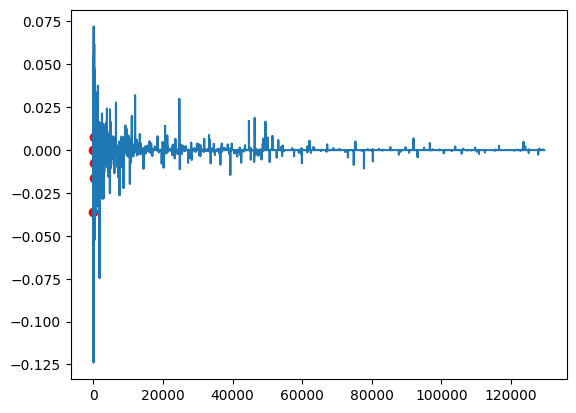

In [19]:
# plot
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(attribution_means.numpy())
scatter_point = [8,9,51,52,53,188,189,231,232,233]
for i in scatter_point:
    ax.scatter(i, attribution_means[i].numpy(), c='red')

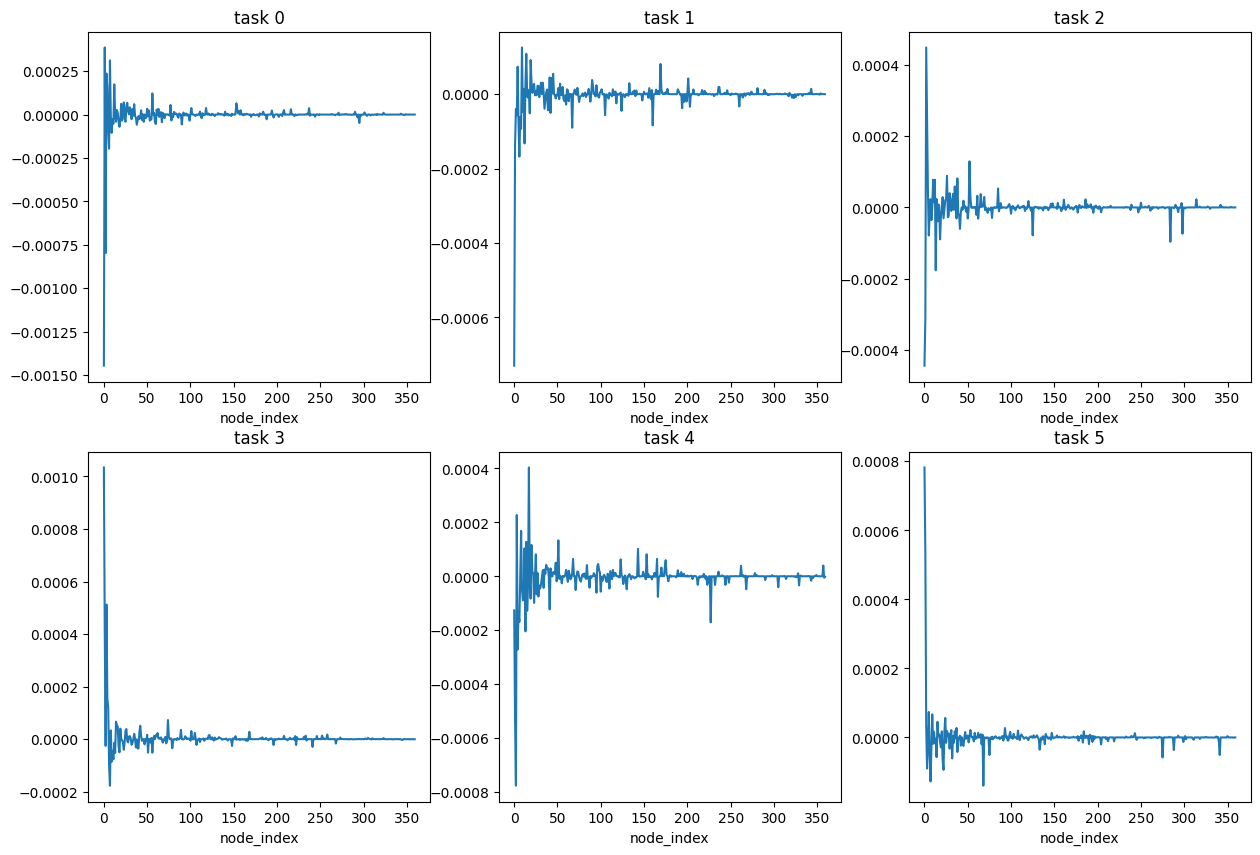

In [52]:
# plot
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    ax[i // 3, i % 3].plot(attribution_means[i].numpy())
    ax[i // 3, i % 3].set_title(f'task {i}')
    ax[i // 3, i % 3].set_xlabel('node_index')


## GNNExplainer

In [242]:
import os
import torch

def files_by_name(dir_path: str, search_string: str) -> list[str]:
    matching_files = []  # List to hold all matching filenames

    # Walk through all directories and files in the given directory
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if search_string in file and 'explanationgcn' in file:
                matching_files.append(os.path.join(root, file))

    return matching_files


dir_path = '../explanations'  
search_string = 'explanation'  

found_files = files_by_name(dir_path, search_string)

attribution_list = []
graph_indices = []
for file_name in found_files:
    file = torch.load(file_name)
    graph_index = int(file_name.split('_')[-1].split('.')[0])
    attribution_list.append(file[0].detach().cpu())
    graph_indices.append(graph_index)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
    ax[i // 3, i % 3].plot(attribution_list[i].node_mask.squeeze(-1).numpy())
    ax[i // 3, i % 3].set_title(f'sample {i}')
    ax[i // 3, i % 3].set_xlabel('node_index')
    scatter_point = [8,9,51,52,53,188,189,231,232,233]
    for j in scatter_point:
        ax[i // 3, i % 3].scatter(j, attribution_list[i].node_mask[j].squeeze(-1).numpy(), c='red')

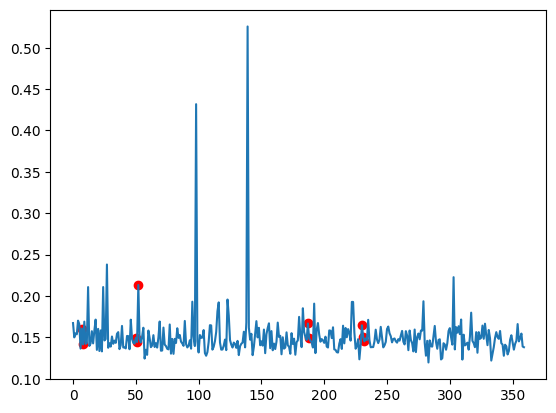

In [243]:
res_node = []
random_sample = np.random.choice(len(attribution_list), 6)
random_sample = range(len(attribution_list))
for i in random_sample:
    res_node.append(attribution_list[i].node_mask.numpy())
res_node = np.stack(res_node)[0]
plt.plot(res_node)
scatter_point = torch.tensor([8,9,51,52,53,188,189,231,232,233]) - 1
for i in scatter_point:
    plt.scatter(i, res_node[i], c='red')

In [194]:
res_node.shape

(6, 360)

In [233]:
# calculate Mean Reciprocal Rank
import torch
import numpy as np

def mrr(score, target):
    _,rank = torch.sort(-score, descending=False)
    _,rank = torch.sort(rank, descending=False)
    ranks = []
    for i in range(len(target)):
        ranks.append(rank[target[i]].item()+1)
    
    rank = torch.tensor(ranks)
    return (1 / rank.float()).mean()

def hit10(score, target):
    _, rank = score.sort(dim=-1, descending=True)
    rank = rank[:30]

    hit = 0
    for i in range(len(target)):
        if target[i] in rank:
            hit += 1
    return hit / 10

def wmrr(score, target):
    _, rank = score.sort(dim=-1, descending=True)
    ranks = []
    for i in range(len(target)):
        ranks.append((rank == target[i]).nonzero().item())
    rank = torch.tensor(ranks)
    return (1 / rank.float() * torch.softmax(rank, 0)).mean()

score = torch.tensor(res_node)
target = torch.tensor([8,9,51,52,53,188,189,231,232,233]) -1
mrr_mamba = []
for i in range(len(score)):
    # print(hit10(score[i], target))
    # print(mrr(score[i], target))
    mrr_mamba.append(hit10(score[i], target))
    # print(wmrr(score[i], target))
    # print('\n')
# mrr(score, target)
mrr_mamba = torch.tensor(mrr_mamba)
mrr_mamba.sort()[0][-17:]

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.2000, 0.2000, 0.3000])

## Mamba Interpret

In [1]:
import os
import torch

def files_by_name(dir_path: str, search_string: str) -> list[str]:
    matching_files = []  # List to hold all matching filenames

    # Walk through all directories and files in the given directory
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if search_string in file:
                matching_files.append(os.path.join(root, file))

    return matching_files


dir_path = '../explanations/mamba'  
search_string = 'interpret'  

found_files = files_by_name(dir_path, search_string)
score_list = []
y_list = []
attribution_list = []
for file_name in found_files:
    file = torch.load(file_name)
    if file[1].dim() != 1:
        score_list.append(file[0].reshape(128,360).detach().cpu())
        attribution_list.append(file[1].reshape(128,360,96).detach().cpu())
        y_list.append(file[2].detach().cpu())
score_list = torch.cat(score_list, dim=0)
attribution_list = torch.cat(attribution_list, dim=0)
y_list = torch.cat(y_list, dim=0)

In [45]:
vars = torch.var(attribution_list, dim=[0]).mean(-1)
bad_feature_id = (-vars).topk(80).indices


In [10]:
best_mrr = 0
best_topk_num = 0

for topk_num in range(20, 120):
    vars = torch.var(attribution_list, dim=[0]).mean(-1)
    bad_feature_id = (-vars).topk(topk_num).indices

    res_vec = []
    for i in range(y_list.shape[0]):
        if y_list[i] == 3:
            res_vec.append(score_list[i])

    res_vec = torch.stack(res_vec, dim=0)
    res_vec = res_vec.mean(dim=0)
    res_vec[bad_feature_id] = 0

    # import matplotlib.pyplot as plt

    # plt.plot(res_vec)
    # scatter_point = torch.tensor([8,9,51,52,53,188,189,231,232,233]) - 1
    # for i in scatter_point:
    #     plt.scatter(i, res_vec[i], c='red')

    def mrr(score, target):
        _,rank = torch.sort(-score, descending=False)
        _,rank = torch.sort(rank, descending=False)
        ranks = []
        for i in range(len(target)):
            ranks.append(rank[target[i]].item()+1)
        
        rank = torch.tensor(ranks)
        return (1 / rank.float()).mean()

    def hit10(score, target):
        _, rank = score.sort(dim=-1, descending=True)
        rank = rank[:50]

        hit = 0
        for i in range(len(target)):
            if target[i] in rank:
                hit += 1
        return hit / 10

    mrr_new = mrr(res_vec, scatter_point)
    if mrr_new > best_mrr:
        best_mrr = mrr_new
        best_topk_num = topk_num


In [12]:
best_mrr

tensor(0.0646)

tensor(0.0634)

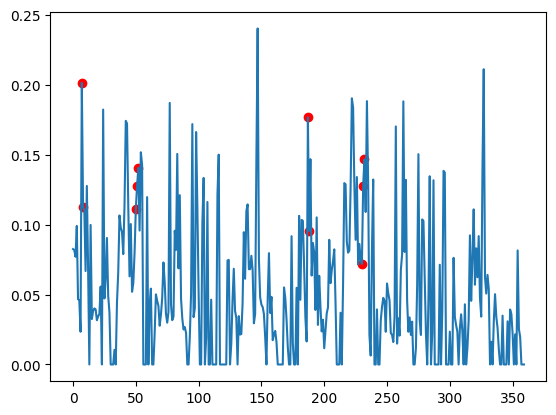

In [47]:
import matplotlib.pyplot as plt

plt.plot(res_vec)
scatter_point = torch.tensor([8,9,51,52,53,188,189,231,232,233]) - 1
for i in scatter_point:
    plt.scatter(i, res_vec[i], c='red')

def mrr(score, target):
    _,rank = torch.sort(-score, descending=False)
    _,rank = torch.sort(rank, descending=False)
    ranks = []
    for i in range(len(target)):
        ranks.append(rank[target[i]].item()+1)
    
    rank = torch.tensor(ranks)
    return (1 / rank.float()).mean()

def hit10(score, target):
    _, rank = score.sort(dim=-1, descending=True)
    rank = rank[:50]

    hit = 0
    for i in range(len(target)):
        if target[i] in rank:
            hit += 1
    return hit / 10

mrr(res_vec, scatter_point)